In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("..")
from core import cacul_CRSP
from core import cacul_CFAP
from core import cacul_limit_c, cacul_limit_u, read_limit
from core import chart_preform
from core import svm_weight_score_matrix

In [2]:
class Params:
    def __init__(self, dist_type, K=100, R=100, ab=0, **kwargs):
        self.dist_type = dist_type
        self.K = K
        self.R = R
        self.ab = ab 
        self.params = kwargs

    def get(self, key, default=None):
        return self.params.get(key, default)

    def get_data_generator(self):
        '''根据分布类型返回相应的数据生成器和相关参数'''
        if self.dist_type == 'multinorm':
            mean1 = self.get('mean1', [0, 0])
            mean2 = self.get('mean2', [self.ab, 0])
            cov1 = self.get('cov1', [[1, 0], [0, 1]])
            cov2 = self.get('cov2', [[1, 0], [0, 1]])
            data_generator = np.random.multivariate_normal
            return data_generator, {'mean': mean1, 'cov': cov1}, {'mean': mean2, 'cov': cov2}

        elif self.dist_type == 'correlated_multinorm':
            mean1 = self.get('mean1', [0, 0])
            mean2 = self.get('mean2', [self.ab, 0])
            cov1 = self.get('cov1', [[1, 1], [1, 1]])
            cov2 = self.get('cov2', [[1, 1], [1, 1]])
            data_generator = np.random.multivariate_normal
            return data_generator, {'mean': mean1, 'cov': cov1}, {'mean': mean2, 'cov': cov2}

        elif self.dist_type == 'gamma':
            a = self.get('a', 1)
            b = self.get('b', 1)
            ab = self.get('ab', self.ab)
            data_generator = lambda size, a=a, b=b, ab=ab: np.random.gamma(shape=a, scale=b, size=(size, 2)) + ab
            return data_generator, {'a': a, 'b': b, 'ab': 0}, {'a': a, 'b': b, 'ab': ab} # prama1和param2分别为ref和mon参数

        else:
            raise ValueError("Unsupported distribution type.")

def ranksum_1_scores(ref_size, win_size, I, params):
    '''根据指定的分布类型生成分数矩阵并存储'''
    from core import ranksum_score_matrix

    # 获取数据生成器和参数
    data_generator, param1, param2 = params.get_data_generator()

    # name前缀
    name_prefix = "IC" if params.ab == 0 else "OC"
    name_suffix = f"I{I}_ref{ref_size}_win{win_size}_ab{params.ab}"
    name = f"{name_prefix}_rank_1_{params.dist_type}_scores_{name_suffix}"

    # 生成数据和分数
    scores = np.zeros((params.R, params.K, I))
    for r in range(params.R):
        RefData = data_generator(size=ref_size * params.K, **param1)
        MonData = data_generator(size=win_size * I, **param2)
        score = ranksum_score_matrix(RefData, MonData, ref_size, win_size, I, params.K)
        scores[r, :, :] = score

    # 存储得分矩阵
    np.savez(name, scores=scores)

def ranksum_2_scores(ref_size, win_size, I, params):
    '''根据指定的分布类型生成分数矩阵并存储'''
    from core import ranksum_2_score_matrix

    # 获取数据生成器和参数
    data_generator, param1, param2 = params.get_data_generator()

    # name前缀
    name_prefix = "IC" if params.ab == 0 else "OC"
    name_suffix = f"I{I}_ref{ref_size}_win{win_size}_ab{params.ab}"
    name = f"{name_prefix}_rank_2_{params.dist_type}_scores_{name_suffix}"

    # 生成数据和分数
    scores = np.zeros((params.R, params.K, I))
    for r in range(params.R):
        RefData = data_generator(size=ref_size * params.K, **param1)
        MonData = data_generator(size=win_size * I, **param2)
        score = ranksum_2_score_matrix(RefData, MonData, ref_size, win_size, I, params.K)
        scores[r, :, :] = score

    # 存储得分矩阵
    np.savez(name, scores=scores)

# if __name__ == '__main__':
#     I = 10
#     ref_size_list = [20, 20, 40]
#     win_size_list = [10, 20, 20]
#     ab_list = [0.25,0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]
#     ## 运行得分计算
#     for ref_size, win_size in zip(ref_size_list, win_size_list):
#             print("IC",I, ref_size, win_size)
#             # # 正太分布N(0,I)
#             multinorm_params = Params('multinorm', K=100, R=100, ab=0)
#             ranksum_1_scores(ref_size, win_size, I, params=multinorm_params)
#             # 相关分布N(0, E)
#             multinorm_params = Params('correlated_multinorm', K=100, R=100, ab=0)
#             ranksum_1_scores(ref_size, win_size, I, params=multinorm_params)
#             # Gamma 分布 G(a,b)
#             multinorm_params = Params('gamma', K=100, R=100, ab=0)
#             ranksum_1_scores(ref_size, win_size, I, params=multinorm_params)



#     ##  OC得分矩阵
#     for ab in ab_list:
#         for ref_size, win_size in zip(ref_size_list, win_size_list):
#                 print("OC",I, ref_size, win_size)
#                 # # 正太分布N(0,I)
#                 multinorm_params = Params('multinorm', K=100, R=100, ab=ab)
#                 ranksum_1_scores(ref_size, win_size, I, params=multinorm_params)
#                 # 相关分布N(0, E)
#                 multinorm_params = Params('correlated_multinorm', K=100, R=100, ab=ab)
#                 ranksum_1_scores(ref_size, win_size, I, params=multinorm_params)
#                 # Gamma 分布 G(a,b)
#                 multinorm_params = Params('gamma', K=100, R=100, ab=ab)
#                 ranksum_1_scores(ref_size, win_size, I, params=multinorm_params)


CL_list_rank: [12.822580645161288, 13.341219512195119, 11.41106557377049]
      MWR_I:(m,n)=(20,10)  MWR_I:(m,n)=(20,20)  MWR_I:(m,n)=(40,20)
0.25             0.009955             0.009955             0.029598
0.50             0.009955             0.009955             0.095618
0.75             0.029598             0.067836             0.285068
1.00             0.067836             0.166098             0.651322
1.25             0.157567             0.438021             0.941393
1.50             0.342060             0.688183             0.996826
1.75             0.558471             0.905317             0.999970
2.00             0.758591             0.989992             1.000000


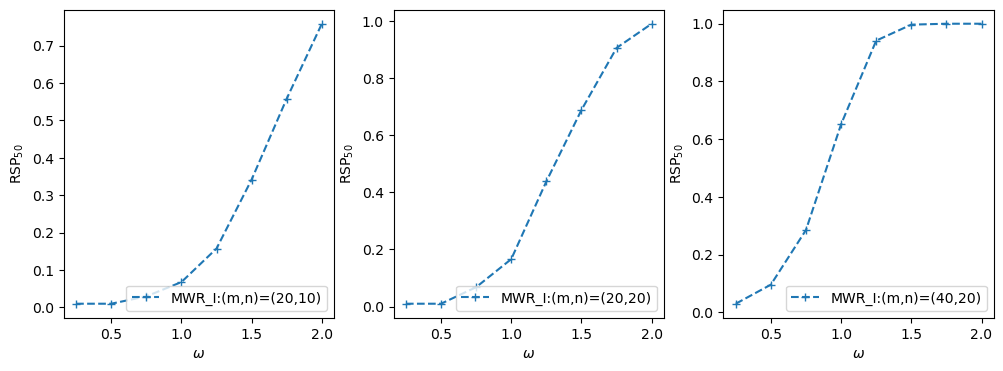

In [4]:
# ## ranksum 2
# # ##  IC得分矩阵
I = 10
ref_size_list = [20, 20, 40]
win_size_list = [10, 20, 20]
ab_list = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]


## 2. IC 计算控制限
CL_list_rank = []
for ref_size, win_size in zip(ref_size_list, win_size_list):
    name = f'IC_rank_1_multinorm_scores_I{I}_ref{ref_size}_win{win_size}_ab{0}'
    data = np.load(name + '.npz')
    IC_scores = data['scores']

    
    #condition 的CFAP
    CL,CFAP = cacul_limit_c(IC_scores, FAP0=0.1, err=0.01)
    CFAP_50, CFAP_75, CFAP_95, CSDFAP = chart_preform(CFAP)
    CL_list_rank.append(CL)

print('CL_list_rank:',CL_list_rank)


## 3. OC 计算不同偏移量ab下的RSP
columns=['MWR_I:(m,n)=(20,10)','MWR_I:(m,n)=(20,20)','MWR_I:(m,n)=(40,20)']
abmean_CRSP50_rank_1 =pd.DataFrame(np.ones((len(ab_list),len(columns))), index=ab_list, columns=columns)
for i,(ref_size,win_size,CL) in enumerate(zip(ref_size_list,win_size_list,CL_list_rank)):
    for ab in ab_list:
        name = "OC_"+ "rank_1_multinorm_scores_" + f"I{I}_ref{ref_size}_win{win_size}_ab{ab}"
        data = np.load(name + '.npz')
        OC_scores = data['scores']
        CRSP = cacul_CRSP(CL,OC_scores)
        crsp_50 = np.median(CRSP)
        abmean_CRSP50_rank_1.loc[ab,columns[i]] = crsp_50
print(abmean_CRSP50_rank_1)
# 对columns_MWR_II重命名,并保存abmean_CRSP50_rank
columns_MWR_II= ['MWR_I:(m,n)=(20,10)', 'MWR_I:(m,n)=(20,20)', 'MWR_I:(m,n)=(40,20)']
abmean_CRSP50_rank_1.columns=columns_MWR_II
abmean_CRSP50_rank_1.to_csv('abmean_CRSP50_rank_1_multinorm.csv')


linestyle_list=['--',':']
markers_list=['+','*',]
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(abmean_CRSP50_rank_1[columns[i]],markers_list[0],linestyle=linestyle_list[0])
    plt.legend([columns[i], columns[i]],loc='lower right')
    plt.xlabel('$\omega$')
    plt.ylabel('RSP$_{50}$')
    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.22,hspace=0.15)
plt.show()



   Unnamed: 0  NMFHP:(m,n)=(20,10)  NMFHP:(m,n)=(20,20)  NMFHP:(m,n)=(40,20)
0        0.25             0.020012             0.024400             0.024400
1        0.50             0.039092             0.039596             0.079211
2        0.75             0.103416             0.093321             0.330474
3        1.00             0.268044             0.234419             0.781986
4        1.25             0.578764             0.497620             0.986035
5        1.50             0.880218             0.783614             1.000000
6        1.75             0.985427             0.957815             1.000000
7        2.00             1.000000             1.000000             1.000000


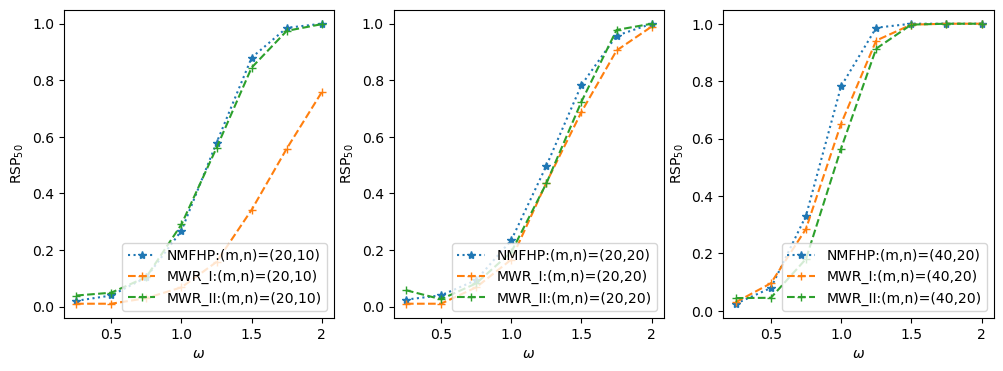

In [5]:
abmean_CRSP50 = pd.read_csv('abmean_CRSP50_multinorm.csv')
abmean_CRSP50_rank_I = pd.read_csv('abmean_CRSP50_rank_1_multinorm.csv')
abmean_CRSP50_rank_II = pd.read_csv('abmean_CRSP50_rank_2_multinorm.csv')

ab_list = [0.5, 1.0, 1.5,  2]

print(abmean_CRSP50)
linestyle_list=['--',':']
markers_list=['+','*',]
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    column_index = i+1
    plt.plot(abmean_CRSP50.iloc[:, column_index],markers_list[1],linestyle=linestyle_list[1])
    plt.plot(abmean_CRSP50_rank_I.iloc[:, column_index],markers_list[0],linestyle=linestyle_list[0])
    plt.plot(abmean_CRSP50_rank_II.iloc[:, column_index],markers_list[0],linestyle=linestyle_list[0])
    plt.legend([abmean_CRSP50.columns[column_index],abmean_CRSP50_rank_I.columns[column_index],abmean_CRSP50_rank_II.columns[column_index]],loc='lower right')
    #x轴的刻度 
    plt.xticks([1,3,5,7],ab_list)
    plt.xlabel('$\omega$')
    plt.ylabel('RSP$_{50}$')
    plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.22,hspace=0.15)
    #保存为高清pdf文件
    plt.savefig('figure7_b.pdf',dpi=300,bbox_inches='tight')
        
